In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import bz2
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.ft.txt.bz2', 'test.ft.txt.bz2']


## **FastText File Reading** ##

In [2]:
trainfile = bz2.BZ2File('../input/train.ft.txt.bz2','r')
lines = trainfile.readlines()

In [3]:
lines[1]

b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"

In [4]:
docSentimentList=[]
def getDocumentSentimentList(docs,splitStr='__label__'):
    for i in range(len(docs)):
        #print('Processing doc ',i,' of ',len(docs))
        text=str(lines[i])
        #print(text)
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        #print('First half:',secHalf[0],'\nsecond half:',secHalf[2:len(secHalf)-1])
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [5]:
docSentimentList=getDocumentSentimentList(lines[:1000000],splitStr='__label__')

Done!!


In [6]:
train_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
train_df.head()

,Text,Sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


## **Text Preprocessing**##

In [7]:
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1

In [8]:
train_df['Sentiment'].value_counts()

1    505678
0    494322
Name: Sentiment, dtype: int64

In [9]:
train_df['word_count'] = train_df['Text'].str.lower().str.split().apply(len)
train_df.head()

,Text,Sentiment,word_count
0,Stuning even for the non-gamer: This sound tra...,1,80
1,The best soundtrack ever to anything.: I'm rea...,1,97
2,Amazing!: This soundtrack is my favorite music...,1,129
3,Excellent Soundtrack: I truly like this soundt...,1,118
4,"Remember, Pull Your Jaw Off The Floor After He...",1,87


In [10]:
import string 
def remove_punc(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)

In [11]:
train_df['Text'] = train_df['Text'].apply(remove_punc)
train_df.shape

(1000000, 3)

In [12]:
train_df.head()

,Text,Sentiment,word_count
0,Stuning even for the nongamer This sound track...,1,80
1,The best soundtrack ever to anything Im readin...,1,97
2,Amazing This soundtrack is my favorite music o...,1,129
3,Excellent Soundtrack I truly like this soundtr...,1,118
4,Remember Pull Your Jaw Off The Floor After Hea...,1,87


In [13]:
len(train_df['word_count'][train_df['word_count']<=25])

63720

In [14]:
train_df1 = train_df[:][train_df['word_count']<=25]
train_df1.head()

,Text,Sentiment,word_count
44,autumn got this for my daughter in NC she is n...,1,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,25
77,Smells divine This is my second bottle of shee...,1,25
78,Very disappointed This perfume is just AWFUL S...,0,24
99,Caution These tracks are not the original vers...,0,22


In [15]:
train_df1['Sentiment'].value_counts()

1    39932
0    23788
Name: Sentiment, dtype: int64

## **CountVectorized Representation** ##

In [16]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
st_wd = text.ENGLISH_STOP_WORDS
c_vector = CountVectorizer(stop_words = st_wd,min_df=.0001,lowercase=1)
X_counts = c_vector.fit_transform(train_df1['Text'].values)

In [17]:
X_counts

<63720x8915 sparse matrix of type '<class 'numpy.int64'>'
	with 590872 stored elements in Compressed Sparse Row format>

In [18]:
from sklearn.model_selection import train_test_split
y = train_df1['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.1, random_state=42)

In [19]:
X_train = X_train.todense()
X_test = X_test.todense()

In [20]:
X_train.shape

(57348, 8915)

 ## **Keras NN Model** ##

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model1=  Sequential()
model1.add(Dense(1000,input_shape=(8915,),activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist = model1.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1)

Using TensorFlow backend.


Epoch 1/6
57348/57348 [==============================] - 10s 177us/step - loss: 0.2813 - acc: 0.8794
Epoch 2/6
57348/57348 [==============================] - 4s 71us/step - loss: 0.1787 - acc: 0.9305
Epoch 3/6
57348/57348 [==============================] - 4s 77us/step - loss: 0.1147 - acc: 0.9600
Epoch 4/6
57348/57348 [==============================] - 4s 72us/step - loss: 0.0532 - acc: 0.9855
Epoch 5/6
57348/57348 [==============================] - 4s 75us/step - loss: 0.0194 - acc: 0.9961
Epoch 6/6
57348/57348 [==============================] - 4s 71us/step - loss: 0.0071 - acc: 0.9986


In [22]:
model1.evaluate(X_test, y_test, batch_size=128)

6372/6372 [==============================] - 0s 58us/step


[0.5397346347327211, 0.8882611427603468]

In [23]:
model1.evaluate(X_train, y_train, batch_size=128)

57348/57348 [==============================] - 2s 34us/step


[0.0032890631221668726, 0.9995815024063611]

In [24]:
model2=  Sequential()
model2.add(Dense(1000,input_shape=(8915,),activation='relu'))
model2.add(Dense(500,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist2 = model2.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1)


Epoch 1/6
57348/57348 [==============================] - 5s 93us/step - loss: 0.2793 - acc: 0.8815
Epoch 2/6
57348/57348 [==============================] - 4s 78us/step - loss: 0.1521 - acc: 0.9429
Epoch 3/6
57348/57348 [==============================] - 4s 76us/step - loss: 0.0471 - acc: 0.9852
Epoch 4/6
57348/57348 [==============================] - 5s 81us/step - loss: 0.0077 - acc: 0.9978
Epoch 5/6
57348/57348 [==============================] - 4s 77us/step - loss: 0.0025 - acc: 0.9995
Epoch 6/6
57348/57348 [==============================] - 5s 79us/step - loss: 0.0014 - acc: 0.9998


In [25]:
model3=  Sequential()
model3.add(Dense(2000,input_shape=(8915,),activation='relu'))
model3.add(Dense(1000,activation='relu'))
model3.add(Dense(500,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist3 = model3.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1)


Epoch 1/6
57348/57348 [==============================] - 9s 165us/step - loss: 0.2790 - acc: 0.8832
Epoch 2/6
57348/57348 [==============================] - 7s 130us/step - loss: 0.1461 - acc: 0.9446
Epoch 3/6
57348/57348 [==============================] - 7s 129us/step - loss: 0.0377 - acc: 0.9875
Epoch 4/6
57348/57348 [==============================] - 7s 130us/step - loss: 0.0066 - acc: 0.9980
Epoch 5/6
57348/57348 [==============================] - 7s 130us/step - loss: 0.0023 - acc: 0.9993
Epoch 6/6
57348/57348 [==============================] - 8s 140us/step - loss: 0.0024 - acc: 0.9993


In [26]:
model2.evaluate(X_test, y_test, batch_size=128)

6372/6372 [==============================] - 0s 70us/step


[0.8057562848418596, 0.8903013180429203]

In [27]:
model3.evaluate(X_test, y_test, batch_size=128)

6372/6372 [==============================] - 0s 71us/step


[0.8161278506232296, 0.8920276212527628]

## ** Loss Curve and Accuracy Plot ** ## 

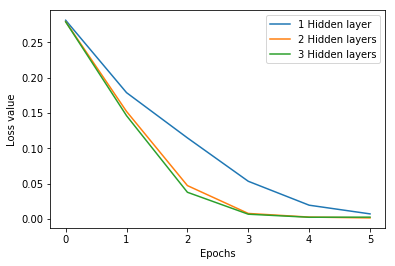

In [28]:
import matplotlib.pyplot as plt
loss_curve = hist.history['loss']
epoch_c = list(range(len(loss_curve)))
loss_curve2 = hist2.history['loss']
epoch_c = list(range(len(loss_curve)))
loss_curve3 = hist3.history['loss']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.plot(epoch_c,loss_curve,label='1 Hidden layer')
plt.plot(epoch_c,loss_curve2,label='2 Hidden layers')
plt.plot(epoch_c,loss_curve3,label='3 Hidden layers')
plt.legend()
plt.show()

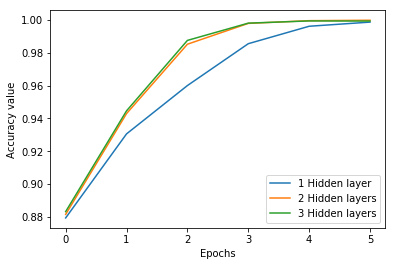

In [29]:
acc_curve = hist.history['acc']
epoch_c = list(range(len(loss_curve)))
acc_curve2 = hist2.history['acc']
epoch_c = list(range(len(loss_curve)))
acc_curve3 = hist3.history['acc']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.plot(epoch_c,acc_curve,label='1 Hidden layer')
plt.plot(epoch_c,acc_curve2,label='2 Hidden layers')
plt.plot(epoch_c,acc_curve3,label='3 Hidden layers')
plt.legend()
plt.show()